# W200 Project 2
## Data analysis: Mapping the Heating Data of Cities on a Map

### 1. Introduction
This notebook attempts to use geopandas to visualize the heating pattern across cities.  If time permits, exploration on merging with UN city-based data will be explored.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# loads the "largest_city_list.csv" and "metadata_largest_city.csv"
city_list = pd.read_csv('data_files/largest_city_list.csv')
metadata = pd.read_csv('data_files/metadata_largest_city.csv', index_col = 'City')

# a fucntion to load the 3 523 individual city csv:
def retrieve_city_data():
    '''
    Reads in all city based csv files.  Run at start of session by default.
    '''
    city_data = {}
    
    for city in city_list.city:
        filename = city + '.csv'
        city_data.update({city: pd.read_csv(filename)})
    
    return city_data

### 2. Preparing the data
This is basically repeating the steps done for Part 3 of the original notebook file analyzing regional heating patterns.

In [2]:
# base data with all needed columns included
base_data = metadata.copy()
base_data['Warming_since_1960'] = city_list.set_index('city').warming_since_1960

# adds the north/south hemisphere categorization
base_data['Hemisphere'] = 'north'
base_data.loc[base_data.Latitude < 0, 'Hemisphere'] = 'south'

# adds the tropical/sub-tropical/temperate/frigid zones categorization
base_data['Climate_zone'] = 'tropical'
base_data.loc[(base_data.Latitude < -23.43644) | (base_data.Latitude > 23.43644), 'Climate_zone'] = 'sub-tropical'
base_data.loc[(base_data.Latitude < -35) | (base_data.Latitude > 35), 'Climate_zone'] = 'temperate'
base_data.loc[(base_data.Latitude < -66.5) | (base_data.Latitude > 66.5), 'Climate_zone'] = 'frigid'

# adds the natural time zones.
base_data['Natural_time_zone'] = 'UTC'
for i in range(12):
    base_data.loc[(base_data.Longitude < (-7.5 - 15 * i)), 'Natural_time_zone'] = 'UTC-' + str(i+1)
    base_data.loc[(base_data.Longitude > (7.5 + 15 * i)), 'Natural_time_zone'] = 'UTC+' + str(i+1)
    
print("Showing the value counts of the added columns")
for column in ['Hemisphere', 'Climate_zone', 'Natural_time_zone']:
    print(f"\nThe following is the value counts of column {column}:")
    print(f"{base_data[column].value_counts()}")

Showing the value counts of the added columns

The following is the value counts of column Hemisphere:
north    2907
south     616
Name: Hemisphere, dtype: int64

The following is the value counts of column Climate_zone:
tropical        1376
temperate       1249
sub-tropical     896
frigid             2
Name: Climate_zone, dtype: int64

The following is the value counts of column Natural_time_zone:
UTC+8     395
UTC+5     385
UTC       320
UTC+2     306
UTC+1     295
UTC+7     295
UTC-5     235
UTC+9     201
UTC-3     184
UTC+3     181
UTC+6     171
UTC-6     127
UTC-7     115
UTC-8      89
UTC-4      79
UTC+4      64
UTC-1      36
UTC-2      18
UTC+10     16
UTC+12      7
UTC+11      3
UTC-10      1
Name: Natural_time_zone, dtype: int64


### 4. Geo plotting (Part 1)
(i) Plotting the temperature rise (warming since 1960) for cities using a map.

In [3]:
# loading the data frame to geo-pandas

gdf = gpd.GeoDataFrame(base_data.Warming_since_1960, geometry=gpd.points_from_xy(base_data.Longitude, base_data.Latitude))

gdf

,Warming_since_1960,geometry
City,,
A Coruña,2.37,POINT (-8.73000 42.59000)
Aachen,2.83,POINT (6.34000 50.63000)
Aalborg,2.84,POINT (10.33000 57.05000)
Aba,1.55,POINT (8.07000 5.63000)
Abadan,2.89,POINT (48.00000 29.74000)
...,...,...
Zouxian,2.23,POINT (117.35000 36.17000)
Zunyi,0.84,POINT (106.36000 28.13000)
Zurich,2.85,POINT (8.29000 47.42000)


Text(0.5, 1217.7982439999998, 'Warming since 1960 (°C / century)')

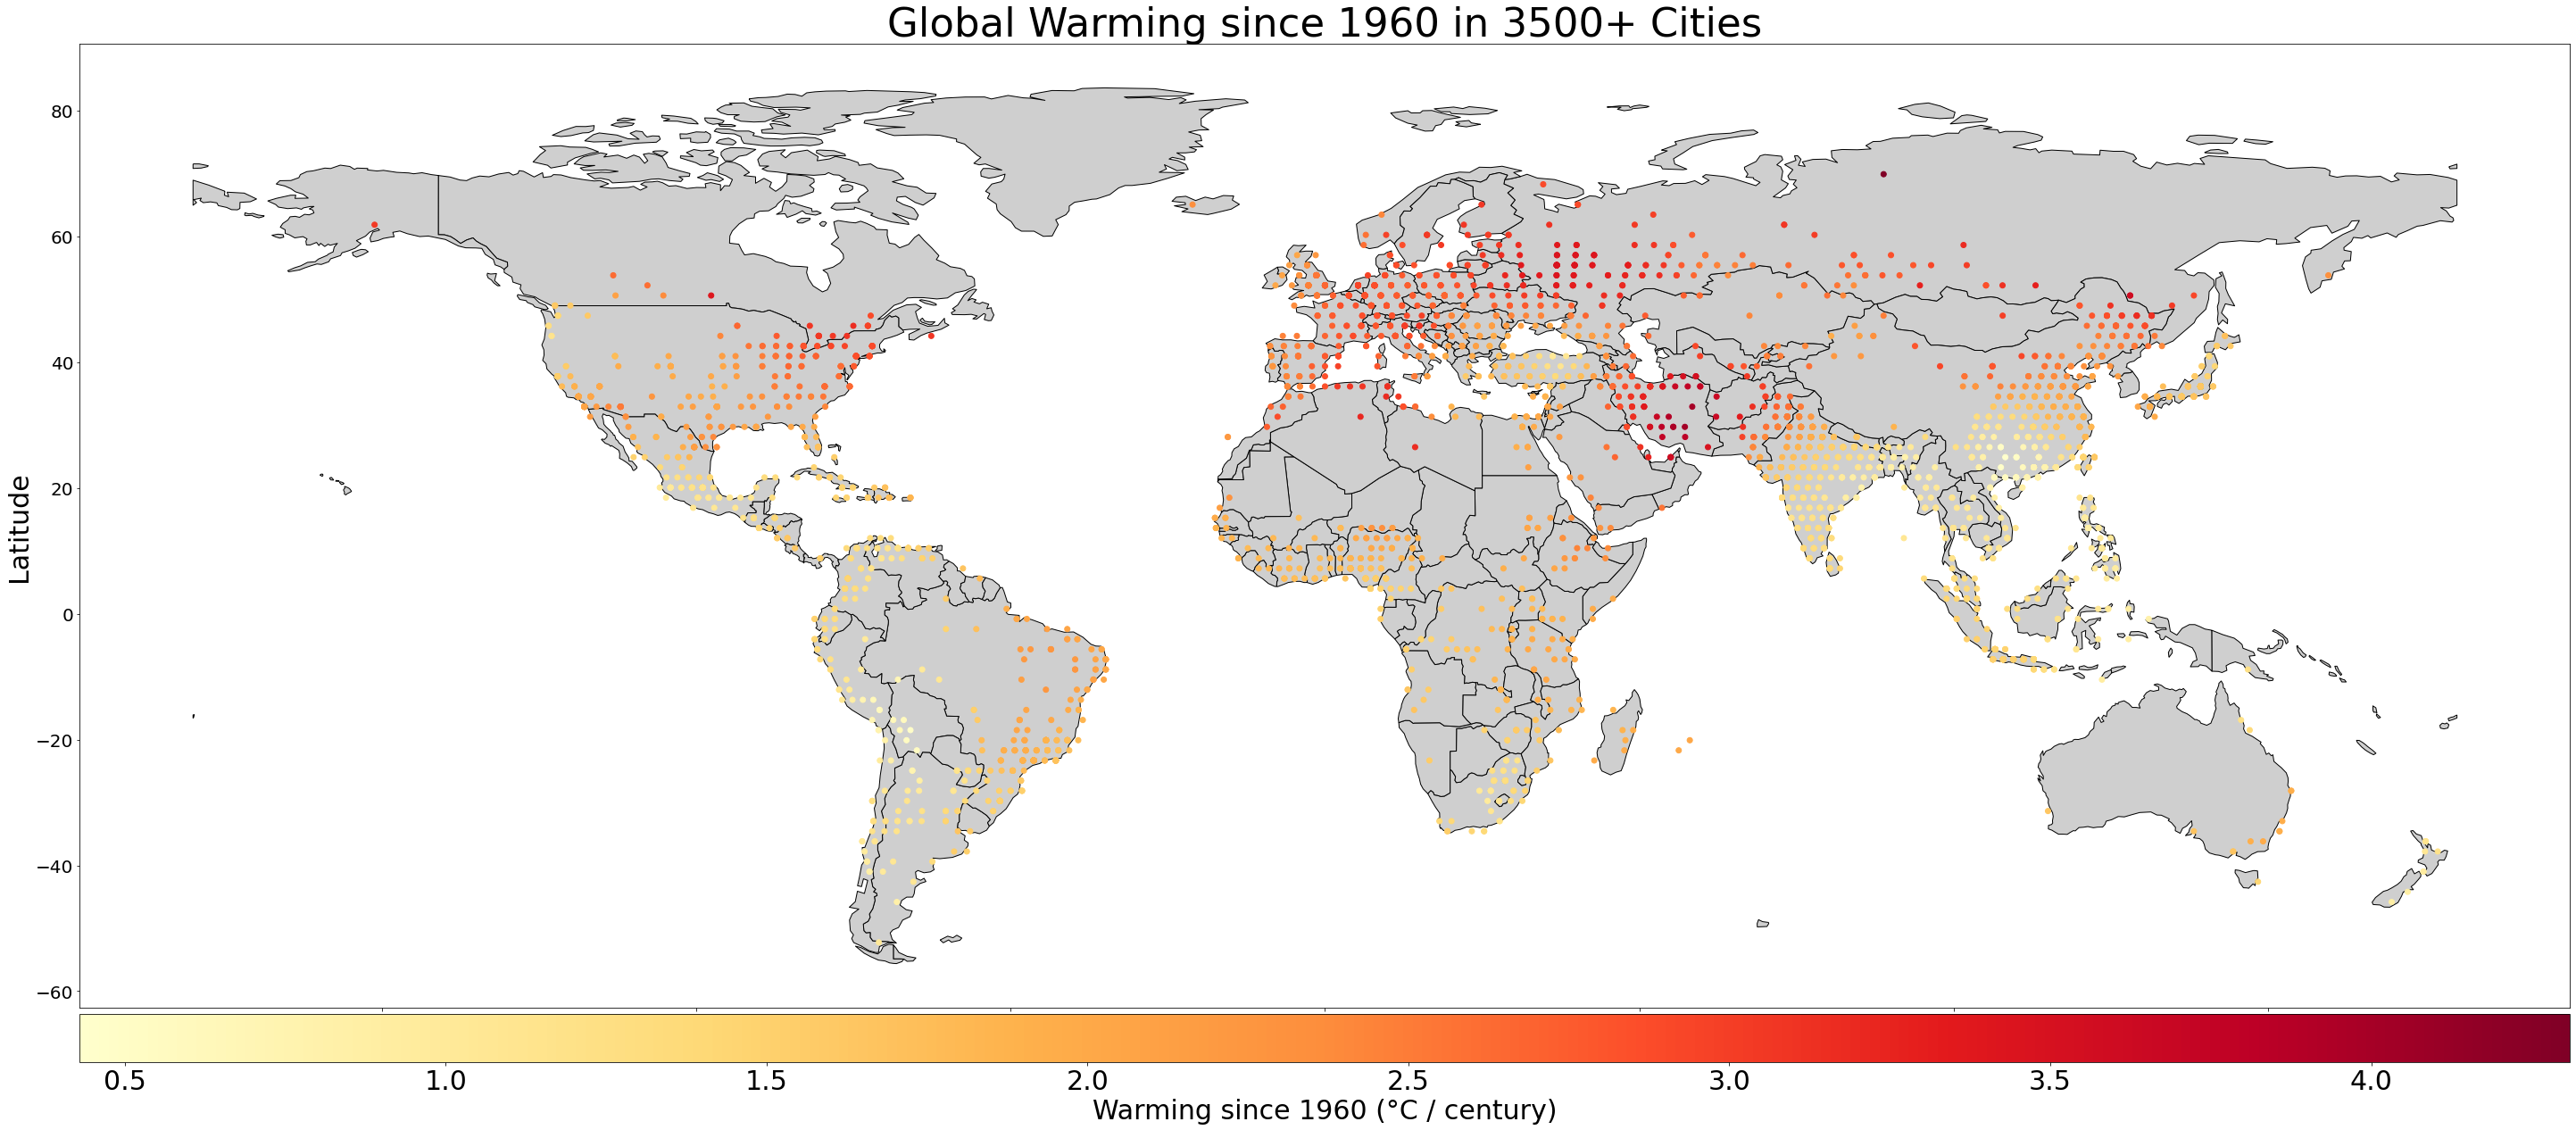

In [20]:
# plotting the graph

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent != 'Antarctica'].plot(color="#cfcfcf", edgecolor='black', figsize=(50, 50))

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

gdf.plot(ax=ax, column='Warming_since_1960', cmap='YlOrRd', legend=True, cax=cax, 
         legend_kwds={'label': "Warming since 1960 (°C / century)",
                      'orientation': "horizontal",
                      'shrink': 0.9})

ax.set_title("Global Warming since 1960 in 3500+ Cities", fontsize=45)
ax.set_ylabel('Latitude', fontsize=30)
ax.tick_params(labelsize=20)

fig = ax.figure
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=30)
cb_ax.set_xlabel('Warming since 1960 (°C / century)', fontsize=30)